<a href="https://colab.research.google.com/github/abhaskumarsinha/Scaling-Down-Transformers-Investigating-Emergent-Phenomena-in-Tiny-Models/blob/main/Experiment%203.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT with A, B, C Language relation

In [1]:
!git clone https://www.github.com/abhaskumarsinha/Corpus2GPT.git

Cloning into 'Corpus2GPT'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1061 (delta 34), reused 3 (delta 3), pack-reused 994 (from 1)
Receiving objects: 100% (1061/1061), 1.87 MiB | 2.51 MiB/s, done.
Resolving deltas: 100% (586/586), done.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras

from Corpus2GPT.utils import LanguagePairDataset as LPD
from Corpus2GPT.tokenizer import SPM_Tokenizer
from Corpus2GPT.models import build_GPT

from Corpus2GPT.inference import Generative_inference

In [4]:
total_vocabs = 8
total_chars = 1

sentence_len = 4
total_instances = 2500
instance_split = '|'
sentence_split = '.'

tokenizer_vocab_size = 30

gpt_input_len = 45
embedding_dim = 400
num_decoder = 2
dropout_rate = 0
num_heads = 20
head_dims = 20
fc_dim_factor = 5
epsilon = 1e-6

epochs = 100
batch_size = 256

In [5]:
dataset = LPD()

dataset.create_vocabs(total_vocabs, total_chars) # Language A
dataset.create_vocabs(total_vocabs, total_chars) # Language B
dataset.create_vocabs(total_vocabs, total_chars) # Language C

A2B, B2A = dataset.create_map(0, 1)
B2C, C2B = dataset.create_map(1, 2)

A2C = {a: B2C[b] for a, b in A2B.items()}  # A -> B -> C
C2A = {c: B2A[b] for c, b in C2B.items()}  # C -> B -> A

dataset.write_dataset_to_file(A2B, B2A, sentence_len, total_instances, './test_translation_dataset.txt', append=False, instance_split=instance_split, sentence_split=sentence_split)
dataset.write_dataset_to_file(B2C, C2B, sentence_len, total_instances, './test_translation_dataset.txt', append=True, instance_split=instance_split, sentence_split=sentence_split)
dataset.write_dataset_to_file(A2C, C2A, sentence_len, 50, './test_translation_dataset.txt', append=True, instance_split=instance_split, sentence_split=sentence_split)

In [6]:
SPM_Tokenizer(vocab_size = tokenizer_vocab_size, corpus='./test_translation_dataset.txt')
tokenizer = SPM_Tokenizer(vocab_model_file='tokenizer_.model', input_size = gpt_input_len+1)

Success!


In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1)
GPT, flops = build_GPT(gpt_input_len, tokenizer_vocab_size, embedding_dim, num_decoder, dropout_rate, num_heads, head_dims, fc_dim_factor, epsilon, optimizer=optimizer)

In [8]:
GPT.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_and_position_embedding         │ (None, 45, 400)             │          30,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 45, 31)              │          12,431 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,533,631 (17.29 MB)

 Trainable params: 4,533,631 (17.29 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
for (X, Y) in tokenizer.load_dataset(['./test_translation_dataset.txt']):
    X, Y = np.array(X), np.array(Y)

In [10]:
inference = Generative_inference(GPT, tokenizer, input_len=gpt_input_len)

class GetTranslationAccuracy(keras.callbacks.Callback):
    def __init__(self, num_test = 5):
        self.num_test = num_test
        self.test_history_A2B = []
        self.test_history_B2C = []
        self.test_history_A2C = []
        self.test_history_C2A = []

    def on_epoch_end(self, epoch, logs=None):
        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2B, B2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2B.append(score)
        print('\n   Total Hits (A2B): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(B2C, C2B, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_B2C.append(score)
        print('   Total Hits (B2C): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2C, C2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2C.append(score)
        print('   Total Hits (A2C): ' + str(score) + ' ')

        #score = 0
        #for i in range(self.num_test):
        #    score += dataset.evaluate_model_accuracy(C2A, A2C, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        #self.test_history_C2A.append(score)
        #print('    Total Hits (C2A): ' + str(score) + '')

callback = GetTranslationAccuracy(5)

In [11]:
history = GPT.fit(X, Y, batch_size = batch_size, epochs = epochs, callbacks=[callback])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.8901   
   Total Hits (A2B): 0.2 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 2.8294
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1.6682
   Total Hits (A2B): 0.1 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 902ms/step - loss: 1.6663
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 1.5913
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1.5904  
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.5496
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - loss: 1.5488
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1.5055
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 815ms/step - loss: 1.5047
Epoch 6/100

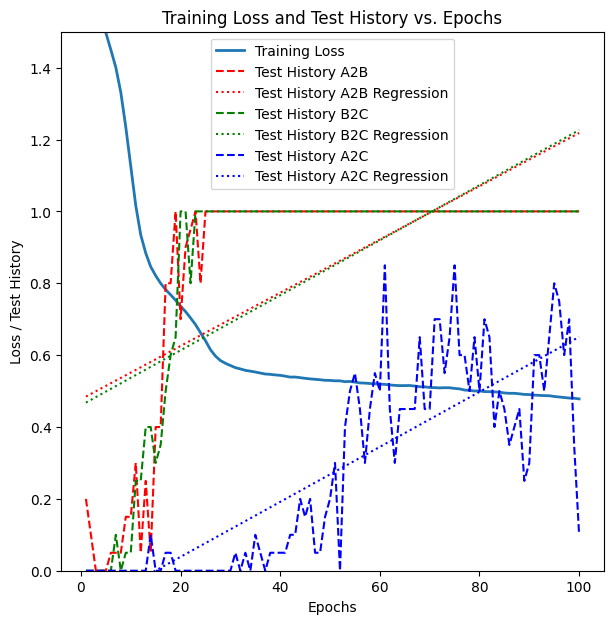

In [12]:
import matplotlib.pyplot as plt
import numpy as np

loss = history.history['loss']
test_history_A2B = callback.test_history_A2B
test_history_B2C = callback.test_history_B2C
test_history_A2C = callback.test_history_A2C
test_history_C2A = callback.test_history_C2A

# Create a figure with a size of 7x7 inches
plt.figure(figsize=(7, 7))

# Plot the cross-entropy loss vs. epochs
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', linewidth=2)

# Function to plot test history and regression for each case
def plot_test_history(test_history, label, color, linestyle):
    epochs = np.arange(1, len(test_history) + 1)
    plt.plot(epochs, test_history, label=label, color=color, linestyle=linestyle)

    # Perform linear regression on test_history
    slope, intercept = np.polyfit(epochs, test_history, 1)
    regression_line = slope * epochs + intercept

    # Plot the regression line
    plt.plot(epochs, regression_line, color=color, linestyle=':', label=f'{label} Regression', linewidth=1.5)

# Plot each test history and its regression
plot_test_history(test_history_A2B, 'Test History A2B', 'r', '--')
plot_test_history(test_history_B2C, 'Test History B2C', 'g', '--')
plot_test_history(test_history_A2C, 'Test History A2C', 'b', '--')
#plot_test_history(test_history_C2A, 'Test History C2A', 'purple', '--')

# Labeling the plot
plt.title('Training Loss and Test History vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Test History')
plt.ylim(0, 1.5)

# Show the plot legend
plt.legend()

plt.savefig("results3.svg", format="svg")

# Display the plot
plt.show()


In [13]:
X_prompt = ""
for _ in range(6):
    X, Y, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
    X_prompt += X + " . " + Y + " | "

x_test, y_test, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
X_test = X_prompt + x_test + " ."

print(X_test, len(X_test))

v q l w . y b n j | v o w e . y i j g | o e v k . i g y a | l w v q . n j y b | l z o v . n m i y | z v q e . m y b g | l z o v . 129


In [14]:
Y_output = inference.generate(X_test, 8, k_value=1)
print(Y_output, len(Y_output))

m i y | z v q e . m y b g | l z o v . n m i y 45


In [15]:
del GPT
del inference

# GPT with A, B relation only

In [16]:
total_vocabs = 8
total_chars = 1

sentence_len = 4
total_instances = 2500
instance_split = '|'
sentence_split = '.'

tokenizer_vocab_size = 30

gpt_input_len = 45
embedding_dim = 400
num_decoder = 2
dropout_rate = 0
num_heads = 20
head_dims = 20
fc_dim_factor = 5
epsilon = 1e-6

epochs = 100
batch_size = 256

In [17]:
dataset = LPD()

dataset.create_vocabs(total_vocabs, total_chars) # Language A
dataset.create_vocabs(total_vocabs, total_chars) # Language B
dataset.create_vocabs(total_vocabs, total_chars) # Language C

A2B, B2A = dataset.create_map(0, 1)
B2C, C2B = dataset.create_map(1, 2)

A2C = {a: B2C[b] for a, b in A2B.items()}  # A -> B -> C
C2A = {c: B2A[b] for c, b in C2B.items()}  # C -> B -> A

dataset.write_dataset_to_file(A2B, B2A, sentence_len, total_instances, './test_translation_dataset.txt', append=False, instance_split=instance_split, sentence_split=sentence_split)
dataset.write_dataset_to_file(B2C, C2B, sentence_len, total_instances, './test_translation_dataset.txt', append=True, instance_split=instance_split, sentence_split=sentence_split)
#dataset.write_dataset_to_file(A2C, C2A, sentence_len, 50, './test_translation_dataset.txt', append=True, instance_split=instance_split, sentence_split=sentence_split)

In [18]:
SPM_Tokenizer(vocab_size = tokenizer_vocab_size, corpus='./test_translation_dataset.txt')
tokenizer = SPM_Tokenizer(vocab_model_file='tokenizer_.model', input_size = gpt_input_len+1)

Success!


In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1)
GPT, flops = build_GPT(gpt_input_len, tokenizer_vocab_size, embedding_dim, num_decoder, dropout_rate, num_heads, head_dims, fc_dim_factor, epsilon, optimizer=optimizer)

In [20]:
GPT.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_and_position_embedding_1       │ (None, 45, 400)             │          30,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Decoder)                  │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_3 (Decoder)                  │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 45, 31)              │          12,431 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,533,631 (17.29 MB)

 Trainable params: 4,533,631 (17.29 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
for (X, Y) in tokenizer.load_dataset(['./test_translation_dataset.txt']):
    X, Y = np.array(X), np.array(Y)

In [22]:
inference = Generative_inference(GPT, tokenizer, input_len=gpt_input_len)

class GetTranslationAccuracy(keras.callbacks.Callback):
    def __init__(self, num_test = 5):
        self.num_test = num_test
        self.test_history_A2B = []
        self.test_history_B2C = []
        self.test_history_A2C = []
        self.test_history_C2A = []

    def on_epoch_end(self, epoch, logs=None):
        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2B, B2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2B.append(score)
        print('\n   Total Hits (A2B): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(B2C, C2B, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_B2C.append(score)
        print('   Total Hits (B2C): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2C, C2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2C.append(score)
        print('   Total Hits (A2C): ' + str(score) + ' ')

        #score = 0
        #for i in range(self.num_test):
        #    score += dataset.evaluate_model_accuracy(C2A, A2C, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        #self.test_history_C2A.append(score)
        #print('    Total Hits (C2A): ' + str(score) + '')

callback = GetTranslationAccuracy(5)

In [23]:
history = GPT.fit(X, Y, batch_size = batch_size, epochs = epochs, callbacks=[callback])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.0629   
   Total Hits (A2B): 0.05 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 2.9955
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 1.6747
   Total Hits (A2B): 0.1 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 849ms/step - loss: 1.6729
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.5985
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step - loss: 1.5977
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 1.5605
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 861ms/step - loss: 1.5599
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.5250
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 819ms/step - loss: 1.5242
Epoch 6/1

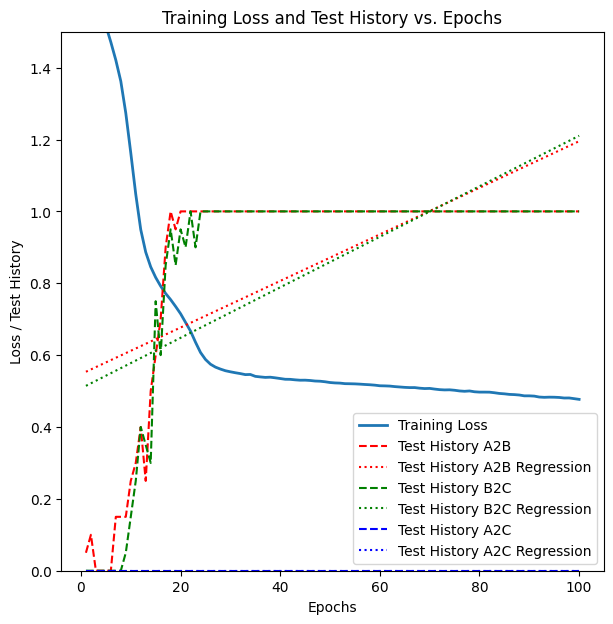

In [24]:
import matplotlib.pyplot as plt
import numpy as np

loss = history.history['loss']
test_history_A2B = callback.test_history_A2B
test_history_B2C = callback.test_history_B2C
test_history_A2C = callback.test_history_A2C
test_history_C2A = callback.test_history_C2A

# Create a figure with a size of 7x7 inches
plt.figure(figsize=(7, 7))

# Plot the cross-entropy loss vs. epochs
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', linewidth=2)

# Function to plot test history and regression for each case
def plot_test_history(test_history, label, color, linestyle):
    epochs = np.arange(1, len(test_history) + 1)
    plt.plot(epochs, test_history, label=label, color=color, linestyle=linestyle)

    # Perform linear regression on test_history
    slope, intercept = np.polyfit(epochs, test_history, 1)
    regression_line = slope * epochs + intercept

    # Plot the regression line
    plt.plot(epochs, regression_line, color=color, linestyle=':', label=f'{label} Regression', linewidth=1.5)

# Plot each test history and its regression
plot_test_history(test_history_A2B, 'Test History A2B', 'r', '--')
plot_test_history(test_history_B2C, 'Test History B2C', 'g', '--')
plot_test_history(test_history_A2C, 'Test History A2C', 'b', '--')
#plot_test_history(test_history_C2A, 'Test History C2A', 'purple', '--')

# Labeling the plot
plt.title('Training Loss and Test History vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Test History')
plt.ylim(0, 1.5)

# Show the plot legend
plt.legend()

plt.savefig("results2.svg", format="svg")

# Display the plot
plt.show()


In [25]:
X_prompt = ""
for _ in range(6):
    X, Y, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
    X_prompt += X + " . " + Y + " | "

x_test, y_test, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
X_test = X_prompt + x_test + " ."

print(X_test, len(X_test))

x t n c . k y a q | j c t s . l q y z | s v n w . z h a p | x t j w . k y l p | n s x v . a z k h | w c n x . p q a k | v w s j . 129


In [26]:
Y_output = inference.generate(X_test, 8, k_value=1)
print(Y_output, len(Y_output))

z k h | w c n x . p q a k | v w s j . h p z l 45


In [27]:
del GPT
del inference

# GPT with language C only

In [28]:
total_vocabs = 8
total_chars = 1

sentence_len = 4
total_instances = 2500
instance_split = '|'
sentence_split = '.'

tokenizer_vocab_size = 30

gpt_input_len = 45
embedding_dim = 400
num_decoder = 2
dropout_rate = 0
num_heads = 20
head_dims = 20
fc_dim_factor = 5
epsilon = 1e-6

epochs = 100
batch_size = 256

In [29]:
dataset = LPD()

dataset.create_vocabs(total_vocabs, total_chars) # Language A
dataset.create_vocabs(total_vocabs, total_chars) # Language B
dataset.create_vocabs(total_vocabs, total_chars) # Language C

A2B, B2A = dataset.create_map(0, 1)
B2C, C2B = dataset.create_map(1, 2)

A2C = {a: B2C[b] for a, b in A2B.items()}  # A -> B -> C
C2A = {c: B2A[b] for c, b in C2B.items()}  # C -> B -> A

#dataset.write_dataset_to_file(A2B, B2A, sentence_len, total_instances, './test_translation_dataset.txt', append=False, instance_split=instance_split, sentence_split=sentence_split)
#dataset.write_dataset_to_file(B2C, C2B, sentence_len, total_instances, './test_translation_dataset.txt', append=True, instance_split=instance_split, sentence_split=sentence_split)
dataset.write_dataset_to_file(A2C, C2A, sentence_len, 50, './test_translation_dataset.txt', append=False, instance_split=instance_split, sentence_split=sentence_split)

In [30]:
SPM_Tokenizer(vocab_size = tokenizer_vocab_size, corpus='./test_translation_dataset.txt')
tokenizer = SPM_Tokenizer(vocab_model_file='tokenizer_.model', input_size = gpt_input_len+1)

Success!


In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1)
GPT, flops = build_GPT(gpt_input_len, tokenizer_vocab_size, embedding_dim, num_decoder, dropout_rate, num_heads, head_dims, fc_dim_factor, epsilon, optimizer=optimizer)

In [32]:
GPT.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_and_position_embedding_2       │ (None, 45, 400)             │          30,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_4 (Decoder)                  │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_5 (Decoder)                  │ (None, 45, 400)             │       2,245,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 45, 31)              │          12,431 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,533,631 (17.29 MB)

 Trainable params: 4,533,631 (17.29 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
for (X, Y) in tokenizer.load_dataset(['./test_translation_dataset.txt']):
    X, Y = np.array(X), np.array(Y)

In [34]:
inference = Generative_inference(GPT, tokenizer, input_len=gpt_input_len)

class GetTranslationAccuracy(keras.callbacks.Callback):
    def __init__(self, num_test = 5):
        self.num_test = num_test
        self.test_history_A2B = []
        self.test_history_B2C = []
        self.test_history_A2C = []
        self.test_history_C2A = []

    def on_epoch_end(self, epoch, logs=None):
        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2B, B2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2B.append(score)
        print('\n   Total Hits (A2B): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(B2C, C2B, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_B2C.append(score)
        print('   Total Hits (B2C): ' + str(score) + ' ')

        score = 0
        for i in range(self.num_test):
            score += dataset.evaluate_model_accuracy(A2C, C2A, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        self.test_history_A2C.append(score)
        print('   Total Hits (A2C): ' + str(score) + ' ')

        #score = 0
        #for i in range(self.num_test):
        #    score += dataset.evaluate_model_accuracy(C2A, A2C, sentence_len, inference, 8, 7, num_prompts=6)/self.num_test

        #self.test_history_C2A.append(score)
        #print('    Total Hits (C2A): ' + str(score) + '')

callback = GetTranslationAccuracy(5)

In [35]:
history = GPT.fit(X, Y, batch_size = batch_size, epochs = epochs, callbacks=[callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 3.9889
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 3.9889
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 3.0492
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 3.0492
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.8318
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.8318  
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - loss: 2.6328
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.6328   
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.3820
   Total Hits (A2B): 0.0 
   Total Hits (B2C): 0.0 
   Total Hits (A2C): 0.0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 2.3820
Epoch 6/100
1/1 ━━━━━━━

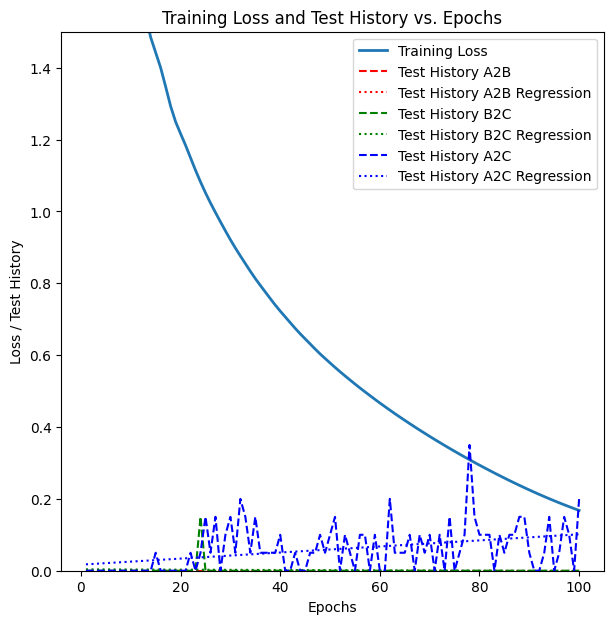

In [36]:
import matplotlib.pyplot as plt
import numpy as np

loss = history.history['loss']
test_history_A2B = callback.test_history_A2B
test_history_B2C = callback.test_history_B2C
test_history_A2C = callback.test_history_A2C
test_history_C2A = callback.test_history_C2A

# Create a figure with a size of 7x7 inches
plt.figure(figsize=(7, 7))

# Plot the cross-entropy loss vs. epochs
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', linewidth=2)

# Function to plot test history and regression for each case
def plot_test_history(test_history, label, color, linestyle):
    epochs = np.arange(1, len(test_history) + 1)
    plt.plot(epochs, test_history, label=label, color=color, linestyle=linestyle)

    # Perform linear regression on test_history
    slope, intercept = np.polyfit(epochs, test_history, 1)
    regression_line = slope * epochs + intercept

    # Plot the regression line
    plt.plot(epochs, regression_line, color=color, linestyle=':', label=f'{label} Regression', linewidth=1.5)

# Plot each test history and its regression
plot_test_history(test_history_A2B, 'Test History A2B', 'r', '--')
plot_test_history(test_history_B2C, 'Test History B2C', 'g', '--')
plot_test_history(test_history_A2C, 'Test History A2C', 'b', '--')
#plot_test_history(test_history_C2A, 'Test History C2A', 'purple', '--')

# Labeling the plot
plt.title('Training Loss and Test History vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Test History')
plt.ylim(0, 1.5)

# Show the plot legend
plt.legend()

plt.savefig("results1.svg", format="svg")

# Display the plot
plt.show()


In [37]:
X_prompt = ""
for _ in range(6):
    X, Y, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
    X_prompt += X + " . " + Y + " | "

x_test, y_test, _ = dataset.create_translate_language_instance(A2B, B2A, sentence_len)
X_test = X_prompt + x_test + " ."

print(X_test, len(X_test))

r x w i . a p f y | r e x i . a s p y | e i r w . s y a f | i w r x . y f a p | k c e w . v l s f | j r i k . n a y v | e w i r . 129


In [38]:
Y_output = inference.generate(X_test, 8, k_value=1)
print(Y_output, len(Y_output))

.  ⁇   ⁇   ⁇   ⁇  | j r i k .  ⁇   ⁇   ⁇   ⁇  | e w i r . h q d h q j 69
